In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import json
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)

plt.style.use('ggplot')

In [255]:
if os.path.isfile('loan.csv'):
    print("loading from csv")
    loans = pd.read_csv('loan.csv', low_memory=False, encoding='iso-8859-1')
else:
    print("loading from zip")
    loans = pd.read_csv('loan.zip',
                        compression='zip',
                        low_memory=False,
                        encoding='iso-8859-1')

loans.info()

loading from zip
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


Getting basic info about the data

In [256]:
loans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
id                                int64
member_id                         int64
loan_amnt                         int64
funded_amnt                       int64
funded_amnt_inv                   float64
term                              object
int_rate                          object
installment                       float64
grade                             object
sub_grade                         object
emp_title                         object
emp_length                        object
home_ownership                    object
annual_inc                        float64
verification_status               object
issue_d                           object
loan_status                       object
pymnt_plan                        object
url                               object
desc                              object
purpose                           object
title                         

Showing the counts of entries per column

In [257]:
loans.count()

id                            39717
member_id                     39717
loan_amnt                     39717
funded_amnt                   39717
funded_amnt_inv               39717
                              ...  
tax_liens                     39678
tot_hi_cred_lim                   0
total_bal_ex_mort                 0
total_bc_limit                    0
total_il_high_credit_limit        0
Length: 111, dtype: int64

In [258]:
num_rows = loans.shape[0]
num_missing = num_rows - loans.count()
print(num_missing)

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64


In [259]:
loans.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

### Finding columns which have NAN

In [260]:
def get_columns_with_nan_percentage(df):
    nan_cols = [{
            "column":c,
            "percentage":round(100*(df[c].isnull().sum()/len(df[c].index)), 2)
            } for c in df.columns if round(100*(df[c].isnull().sum()/len(df[c].index)), 2)>0]
    return nan_cols

In [261]:
def pretty_print_dictionary(data):
    print(json.dumps(data, indent=1))

In [262]:
pretty_print_dictionary(get_columns_with_nan_percentage(loans))

[
 {
  "column": "emp_title",
  "percentage": 6.19
 },
 {
  "column": "emp_length",
  "percentage": 2.71
 },
 {
  "column": "desc",
  "percentage": 32.58
 },
 {
  "column": "title",
  "percentage": 0.03
 },
 {
  "column": "mths_since_last_delinq",
  "percentage": 64.66
 },
 {
  "column": "mths_since_last_record",
  "percentage": 92.99
 },
 {
  "column": "revol_util",
  "percentage": 0.13
 },
 {
  "column": "last_pymnt_d",
  "percentage": 0.18
 },
 {
  "column": "next_pymnt_d",
  "percentage": 97.13
 },
 {
  "column": "last_credit_pull_d",
  "percentage": 0.01
 },
 {
  "column": "collections_12_mths_ex_med",
  "percentage": 0.14
 },
 {
  "column": "mths_since_last_major_derog",
  "percentage": 100.0
 },
 {
  "column": "annual_inc_joint",
  "percentage": 100.0
 },
 {
  "column": "dti_joint",
  "percentage": 100.0
 },
 {
  "column": "verification_status_joint",
  "percentage": 100.0
 },
 {
  "column": "tot_coll_amt",
  "percentage": 100.0
 },
 {
  "column": "tot_cur_bal",
  "percentage": 

#### Deleting columns which have 100% NAN

In [263]:
loans = loans.dropna(how='all', axis=1)
pretty_print_dictionary(get_columns_with_nan_percentage(loans))

[
 {
  "column": "emp_title",
  "percentage": 6.19
 },
 {
  "column": "emp_length",
  "percentage": 2.71
 },
 {
  "column": "desc",
  "percentage": 32.58
 },
 {
  "column": "title",
  "percentage": 0.03
 },
 {
  "column": "mths_since_last_delinq",
  "percentage": 64.66
 },
 {
  "column": "mths_since_last_record",
  "percentage": 92.99
 },
 {
  "column": "revol_util",
  "percentage": 0.13
 },
 {
  "column": "last_pymnt_d",
  "percentage": 0.18
 },
 {
  "column": "next_pymnt_d",
  "percentage": 97.13
 },
 {
  "column": "last_credit_pull_d",
  "percentage": 0.01
 },
 {
  "column": "collections_12_mths_ex_med",
  "percentage": 0.14
 },
 {
  "column": "chargeoff_within_12_mths",
  "percentage": 0.14
 },
 {
  "column": "pub_rec_bankruptcies",
  "percentage": 1.75
 },
 {
  "column": "tax_liens",
  "percentage": 0.1
 }
]


#### Deleting columns with more than 90% empty values

In [264]:
loans = loans.drop(['next_pymnt_d', 'mths_since_last_record'], axis=1)
pretty_print_dictionary(get_columns_with_nan_percentage(loans))

[
 {
  "column": "emp_title",
  "percentage": 6.19
 },
 {
  "column": "emp_length",
  "percentage": 2.71
 },
 {
  "column": "desc",
  "percentage": 32.58
 },
 {
  "column": "title",
  "percentage": 0.03
 },
 {
  "column": "mths_since_last_delinq",
  "percentage": 64.66
 },
 {
  "column": "revol_util",
  "percentage": 0.13
 },
 {
  "column": "last_pymnt_d",
  "percentage": 0.18
 },
 {
  "column": "last_credit_pull_d",
  "percentage": 0.01
 },
 {
  "column": "collections_12_mths_ex_med",
  "percentage": 0.14
 },
 {
  "column": "chargeoff_within_12_mths",
  "percentage": 0.14
 },
 {
  "column": "pub_rec_bankruptcies",
  "percentage": 1.75
 },
 {
  "column": "tax_liens",
  "percentage": 0.1
 }
]


#### Deleting not useful columns like `desc`

In [265]:
loans = loans.drop(['desc'], axis=1)
pretty_print_dictionary(get_columns_with_nan_percentage(loans))

[
 {
  "column": "emp_title",
  "percentage": 6.19
 },
 {
  "column": "emp_length",
  "percentage": 2.71
 },
 {
  "column": "title",
  "percentage": 0.03
 },
 {
  "column": "mths_since_last_delinq",
  "percentage": 64.66
 },
 {
  "column": "revol_util",
  "percentage": 0.13
 },
 {
  "column": "last_pymnt_d",
  "percentage": 0.18
 },
 {
  "column": "last_credit_pull_d",
  "percentage": 0.01
 },
 {
  "column": "collections_12_mths_ex_med",
  "percentage": 0.14
 },
 {
  "column": "chargeoff_within_12_mths",
  "percentage": 0.14
 },
 {
  "column": "pub_rec_bankruptcies",
  "percentage": 1.75
 },
 {
  "column": "tax_liens",
  "percentage": 0.1
 }
]


#### Deleting rows where `revol_util`, `last_pymnt_d`,`last_credit_pull_d`, `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `pub_rec_bankruptcies` or `tax_liens` is NAN

In [266]:
loans = loans[~loans['revol_util'].isnull()]
loans = loans[~loans['last_pymnt_d'].isnull()]
loans = loans[~loans['last_credit_pull_d'].isnull()]
loans = loans[~loans['collections_12_mths_ex_med'].isnull()]
loans = loans[~loans['chargeoff_within_12_mths'].isnull()]
loans = loans[~loans['pub_rec_bankruptcies'].isnull()]
loans = loans[~loans['tax_liens'].isnull()]

pretty_print_dictionary(get_columns_with_nan_percentage(loans))

[
 {
  "column": "emp_title",
  "percentage": 6.18
 },
 {
  "column": "emp_length",
  "percentage": 2.74
 },
 {
  "column": "title",
  "percentage": 0.03
 },
 {
  "column": "mths_since_last_delinq",
  "percentage": 65.79
 }
]


In [267]:
loans = loans.drop(['emp_title', 'title','url'], axis=1)

In [268]:
loans['emp_length'].value_counts()

10+ years    8750
< 1 year     4397
2 years      4291
3 years      4023
4 years      3377
5 years      3235
1 year       3133
6 years      2193
7 years      1747
8 years      1449
9 years      1238
Name: emp_length, dtype: int64

`emp_length` is a ordinal categorical variable, however only 2.74% rows does not have this column, we can drop such rows as even after this we will have a descent data size

In [269]:
loans = loans[~loans['emp_length'].isnull()]
pretty_print_dictionary(get_columns_with_nan_percentage(loans))

[
 {
  "column": "mths_since_last_delinq",
  "percentage": 65.74
 }
]


Dropping `mths_since_last_delinq` as **~65%** are NAN 

In [270]:
loans = loans.drop(['mths_since_last_delinq'], axis=1)

We can delete `member_id` and `id` as they will not help in the analysis

In [271]:
loans = loans.drop(['id','member_id'], axis=1)

Find columns with less than 1 unique values

In [272]:
loans.columns[loans.nunique() <= 1]

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

In [273]:
loans = loans.drop(loans.columns[loans.apply(lambda col:(len(col.unique())<=1))], axis=1)

In [274]:
loans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37833 entries, 0 to 39623
Data columns (total 39 columns):
loan_amnt                  37833 non-null int64
funded_amnt                37833 non-null int64
funded_amnt_inv            37833 non-null float64
term                       37833 non-null object
int_rate                   37833 non-null object
installment                37833 non-null float64
grade                      37833 non-null object
sub_grade                  37833 non-null object
emp_length                 37833 non-null object
home_ownership             37833 non-null object
annual_inc                 37833 non-null float64
verification_status        37833 non-null object
issue_d                    37833 non-null object
loan_status                37833 non-null object
purpose                    37833 non-null object
zip_code                   37833 non-null object
addr_state                 37833 non-null object
dti                        37833 non-null float64
delinq_

In [275]:
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True, figsize=None):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    if figsize:
        sns.set(rc={'figure.figsize':figsize})
    sns.countplot(x=x, y=y, hue=hue, data=dataframe)
    plt.show()

Deleting all rows where the status is `current`

In [276]:
loans = loans[~(loans['loan_status']=='Current')]
loans['loan_defaulted'] = loans['loan_status'].apply(lambda x: 1 if x =='Charged Off' else 0)

### As we have deleted all the current loan, we can drop column `out_prncp` and `out_prncp_inv` since they have only **0**

In [277]:
loans = loans.drop(['out_prncp', 'out_prncp_inv'], axis=1)

In [278]:
loans['term'].value_counts()

 36 months    27496
 60 months     9239
Name: term, dtype: int64

count          36735
unique             2
top        36 months
freq           27496
Name: term, dtype: object
mode:  0     36 months
dtype: object
 36 months    27496
 60 months     9239
Name: term, dtype: int64


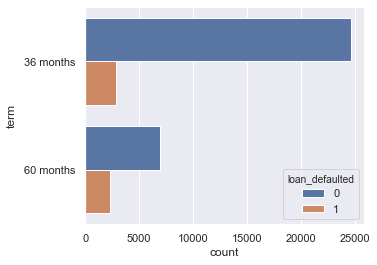

In [279]:
c_palette = ['tab:green', 'tab:red']
categorical_summarized(loans, y = 'term', hue='loan_defaulted', palette=c_palette, figsize=(5,4))

count     36735
unique        7
top           B
freq      11136
Name: grade, dtype: object
mode:  0    B
dtype: object
B    11136
A     9512
C     7451
D     4838
E     2567
F      939
G      292
Name: grade, dtype: int64


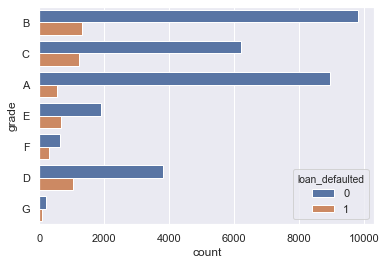

In [280]:
categorical_summarized(loans, y = 'grade', hue='loan_defaulted', palette=c_palette, figsize=(6,4))

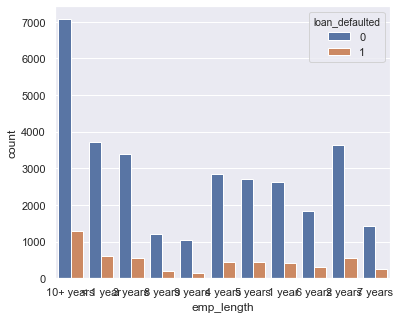

In [281]:
sns.set(rc={'figure.figsize':(6,5)})
sns.countplot(x='emp_length', hue='loan_defaulted', data=loans)

count         36735
unique           11
top       10+ years
freq           8359
Name: emp_length, dtype: object
mode:  0    10+ years
dtype: object
10+ years    8359
< 1 year     4322
2 years      4194
3 years      3940
4 years      3283
5 years      3147
1 year       3062
6 years      2132
7 years      1685
8 years      1405
9 years      1206
Name: emp_length, dtype: int64


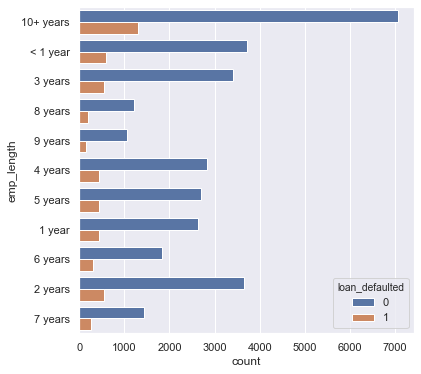

In [282]:
categorical_summarized(loans, y = 'emp_length', hue='loan_defaulted', palette=c_palette, figsize=(6,6))

As, we can see `term` has two values, we can convert it into `category`.

In [283]:
len(loans)

36735

In [284]:
loans.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies,loan_defaulted
0,5000,5000,4975.0000,36 months,10.65%,162.8700,B,B2,10+ years,RENT,...,5000.0000,863.1600,0.0000,0.0000,0.0000,Jan-15,171.6200,May-16,0.0000,0
1,2500,2500,2500.0000,60 months,15.27%,59.8300,C,C4,< 1 year,RENT,...,456.4600,435.1700,0.0000,117.0800,1.1100,Apr-13,119.6600,Sep-13,0.0000,1
2,2400,2400,2400.0000,36 months,15.96%,84.3300,C,C5,10+ years,RENT,...,2400.0000,605.6700,0.0000,0.0000,0.0000,Jun-14,649.9100,May-16,0.0000,0
3,10000,10000,10000.0000,36 months,13.49%,339.3100,C,C1,10+ years,RENT,...,10000.0000,2214.9200,16.9700,0.0000,0.0000,Jan-15,357.4800,Apr-16,0.0000,0
5,5000,5000,5000.0000,36 months,7.90%,156.4600,A,A4,3 years,RENT,...,5000.0000,632.2100,0.0000,0.0000,0.0000,Jan-15,161.0300,Jan-16,0.0000,0


Deleting `pub_rec`, `last_credit_pull_d`, `last_pymnt_amnt` and `last_pymnt_d` as they will not provide any insight the defaulter pattern

In [285]:
loans = loans.drop(['pub_rec', 'last_credit_pull_d',
                    'last_pymnt_amnt', 'last_pymnt_d'], axis=1)

In [286]:
loans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36735 entries, 0 to 39623
Data columns (total 34 columns):
loan_amnt                  36735 non-null int64
funded_amnt                36735 non-null int64
funded_amnt_inv            36735 non-null float64
term                       36735 non-null object
int_rate                   36735 non-null object
installment                36735 non-null float64
grade                      36735 non-null object
sub_grade                  36735 non-null object
emp_length                 36735 non-null object
home_ownership             36735 non-null object
annual_inc                 36735 non-null float64
verification_status        36735 non-null object
issue_d                    36735 non-null object
loan_status                36735 non-null object
purpose                    36735 non-null object
zip_code                   36735 non-null object
addr_state                 36735 non-null object
dti                        36735 non-null float64
delinq_

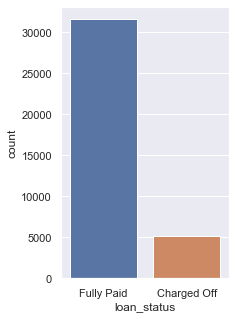

In [287]:
sns.set(rc={'figure.figsize':(3,5)})
sns.countplot(x='loan_status',data=loans)

In [288]:
loans['loan_status'].value_counts()

Fully Paid     31533
Charged Off     5202
Name: loan_status, dtype: int64

Rectangle(xy=(-0.4, 0), width=0.8, height=31533, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=5202, angle=0)


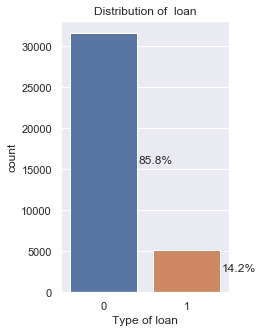

In [289]:
ax = sns.countplot(x='loan_defaulted', data=loans)

plt.title('Distribution of  loan')
plt.xlabel('Type of loan')

total = len(loans['loan_defaulted'])
for p in ax.patches:
    print(p)
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.show()

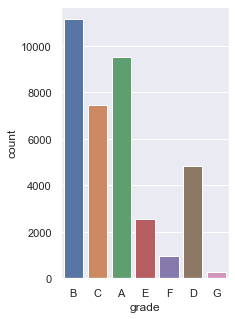

In [290]:
sns.countplot(x='grade',data=loans)

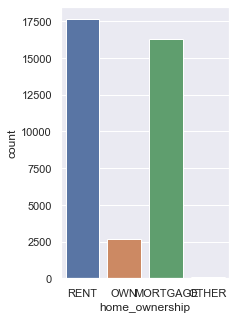

In [291]:
sns.countplot(x='home_ownership',data=loans)

Changing type of columns `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `pub_rec_bankruptcies` and `tax_liens` from float to int

In [292]:
loans_num = loans.select_dtypes(include=['int64','float64'])
loans_num.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,pub_rec_bankruptcies,loan_defaulted
count,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000,36735.0000
mean,11153.4531,10884.2317,10444.7007,324.9947,69468.9407,13.3371,0.1460,0.8689,9.3058,13384.8863,22.1627,12020.2755,11544.8782,9766.7111,2154.8479,1.3409,97.3757,12.4964,0.0417,0.1416
std,7368.3826,7107.2998,7008.0288,208.8390,64063.8854,6.6496,0.4914,1.0675,4.3760,15856.3133,11.4068,8849.6020,8705.6407,7034.1563,2412.1385,7.2043,700.4411,150.2953,0.2005,0.3487
min,500.0000,500.0000,0.0000,16.0800,4000.0000,0.0000,0.0000,0.0000,2.0000,0.0000,2.0000,33.7300,0.0000,0.0000,6.2200,0.0000,0.0000,0.0000,0.0000,0.0000
25%,5500.0000,5425.0000,5000.0000,167.7300,41200.0000,8.2200,0.0000,0.0000,6.0000,3734.5000,14.0000,5590.5861,5292.7300,4641.2650,660.7750,0.0000,0.0000,0.0000,0.0000,0.0000
50%,10000.0000,9600.0000,9000.0000,280.2800,60000.0000,13.4300,0.0000,1.0000,9.0000,8880.0000,20.0000,9832.2917,9375.5800,8000.0000,1328.6800,0.0000,0.0000,0.0000,0.0000,0.0000
75%,15000.0000,15000.0000,14353.3263,429.4500,83000.0000,18.5900,0.0000,1.0000,12.0000,17035.5000,29.0000,16322.6987,15637.7650,13500.0000,2720.6600,0.0000,0.0000,0.0000,0.0000,0.0000
max,35000.0000,35000.0000,35000.0000,1305.1900,6000000.0000,29.9900,11.0000,8.0000,44.0000,149588.0000,90.0000,58563.6799,58563.6800,35000.0200,23563.6800,180.2000,29623.3500,7002.1900,2.0000,1.0000


We can see `pub_rec_bankruptcies` has 3 values, which can be considered as Ordinal categorical variable

In [293]:
loans['pub_rec_bankruptcies'] = loans['pub_rec_bankruptcies'].astype('category')

In [294]:
loans_num.corr(method='kendall')

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,pub_rec_bankruptcies,loan_defaulted
loan_amnt,1.0000,0.9722,0.9053,0.8545,0.2963,0.0463,-0.0321,-0.0028,0.1438,0.2820,0.1891,0.7922,0.7507,0.7837,0.5978,-0.0158,0.0453,0.0370,-0.0211,0.0431
funded_amnt,0.9722,1.0000,0.9296,0.8766,0.2931,0.0462,-0.0317,-0.0031,0.1418,0.2779,0.1853,0.8081,0.7664,0.8046,0.6041,-0.0152,0.0454,0.0374,-0.0214,0.0417
funded_amnt_inv,0.9053,0.9296,1.0000,0.8171,0.2793,0.0479,-0.0345,-0.0108,0.1330,0.2608,0.1779,0.7692,0.8113,0.7594,0.5825,-0.0236,0.0415,0.0323,-0.0259,0.0299
installment,0.8545,0.8766,0.8171,1.0000,0.2870,0.0414,-0.0206,-0.0014,0.1346,0.2750,0.1677,0.7519,0.7075,0.7256,0.5531,-0.0127,0.0273,0.0224,-0.0195,0.0223
annual_inc,0.2963,0.2931,0.2793,0.2870,1.0000,-0.0747,0.0279,0.0274,0.2117,0.2743,0.3017,0.2760,0.2656,0.2733,0.2014,-0.0247,-0.0417,-0.0429,-0.0016,-0.0541
dti,0.0463,0.0462,0.0479,0.0414,-0.0747,1.0000,-0.0312,0.0090,0.2141,0.2235,0.1617,0.0378,0.0392,0.0234,0.0765,-0.0064,0.0233,0.0174,0.0060,0.0372
delinq_2yrs,-0.0321,-0.0317,-0.0345,-0.0206,0.0279,-0.0312,1.0000,0.0100,0.0047,-0.0694,0.0574,-0.0258,-0.0295,-0.0362,0.0154,0.0398,0.0145,0.0159,0.0008,0.0166
inq_last_6mths,-0.0028,-0.0031,-0.0108,-0.0014,0.0274,0.0090,0.0100,1.0000,0.0766,-0.0182,0.0835,-0.0201,-0.0266,-0.0319,0.0181,0.0285,0.0432,0.0374,0.0192,0.0648
open_acc,0.1438,0.1418,0.1330,0.1346,0.2117,0.2141,0.0047,0.0766,1.0000,0.2726,0.5230,0.1265,0.1197,0.1242,0.0983,-0.0316,-0.0146,-0.0211,0.0095,-0.0053
revol_bal,0.2820,0.2779,0.2608,0.2750,0.2743,0.2235,-0.0694,-0.0182,0.2726,1.0000,0.2607,0.2475,0.2344,0.2319,0.2327,-0.0233,0.0042,-0.0022,-0.0232,0.0184


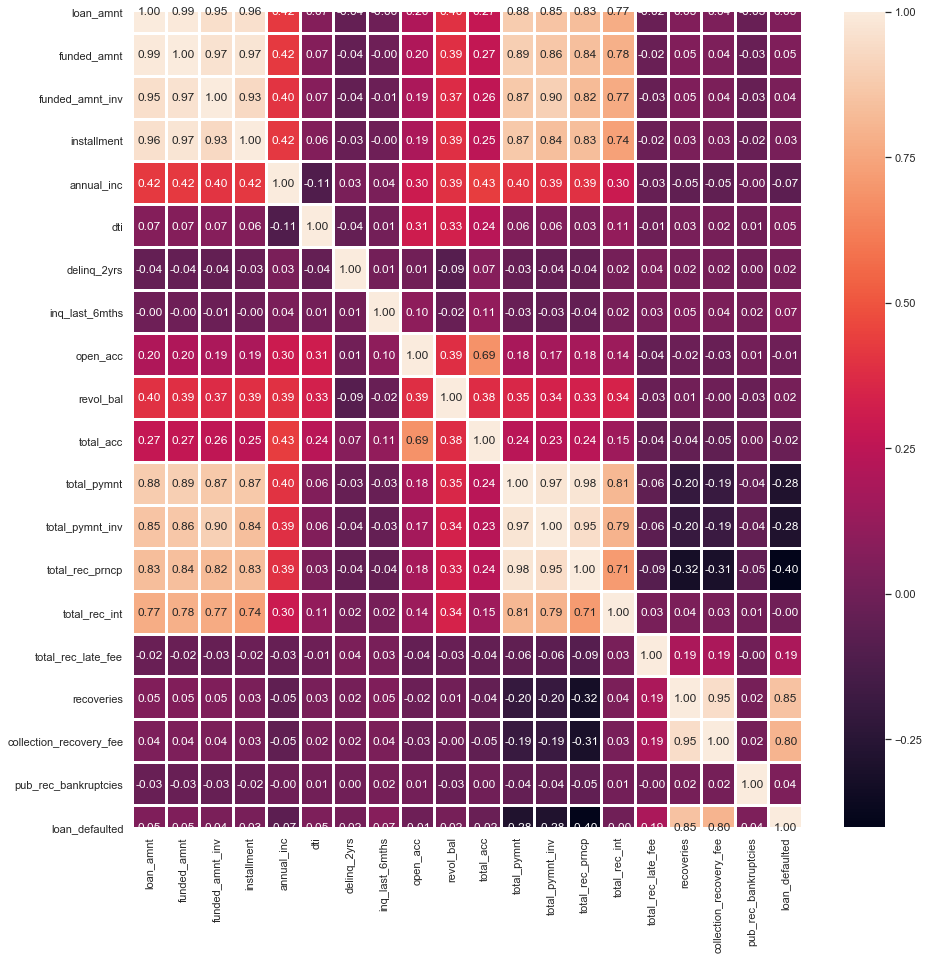

In [295]:
sns.set(rc={'figure.figsize':(15,15)})
sns.set()
sns.heatmap(loans_num.corr(method='spearman'), annot=True, fmt='.2f', linewidths=2)

sns.set()

In [296]:
#sns.pairplot(loans_num)

In [297]:
def get_lower_upper_bound(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    iqr = q3-q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return lower_bound, upper_bound

In [298]:
def get_outlier_iqr(data):
    lower, upper = get_lower_upper_bound(data)
    return data[np.where((data > upper) | (data < lower))]


In [299]:
loans['earliest_cr_line'].value_counts()

Oct-99    352
Nov-98    348
Dec-98    326
Oct-00    325
Nov-99    304
         ... 
Jun-72      1
Nov-62      1
Mar-63      1
Feb-67      1
Feb-69      1
Name: earliest_cr_line, Length: 513, dtype: int64